This notebook provides a fast on GPUs yet precise way of computing the nuclear norm of matrices via its dual formulation and polynomial iterations.
The nuclear norm of $X \in \mathbb{R}^{m \times n}$ is defined as
$$
\|X\|_* = \sum_{i=1}^{\min{m, n}} \sigma_i,
$$
and its dual formulation is
$$
\|X\|_* = \sup_{\|Q\|_2 \leq 1} \operatorname{tr}(Q^TX) = \operatorname{tr}(VU^TX),
$$
where $\sigma, U$ and $V$ are obtained from the SVD of $X$. It is easy to verify the last identity, as
$$
\operatorname{tr}(VU^TX) = \operatorname{tr}(U^TXV) = \operatorname{tr}(U^TU\operatorname{diag}(\sigma) V^TV) = \operatorname{tr}(\operatorname{diag}(\sigma))
$$

Using ploynomial iterations in a similar vein to what is described in https://docs.modula.systems/algorithms/newton-schulz/, we can compute $UV^T$ fast.

The result is a fairly efficient (on GPUs) way of getting the nuclear norm.

In [36]:
import torch
import time
import pandas as pd


@torch.no_grad()
def get_q(M: torch.Tensor, steps: int = 5, eps: float = 1e-7) -> torch.Tensor:
    abc_list = [
        (3955 / 1024, -8306 / 1024, 5008 / 1024),
        (3735 / 1024, -6681 / 1024, 3463 / 1024),
        (3799 / 1024, -6499 / 1024, 3211 / 1024),
        (4019 / 1024, -6385 / 1024, 2906 / 1024),
        (2677 / 1024, -3029 / 1024, 1162 / 1024),
        (2172 / 1024, -1833 / 1024, 682 / 1024),
    ]
    transpose = M.shape[1] > M.shape[0]
    M = M.bfloat16()
    if transpose:
        M = M.T
    M = M / torch.linalg.norm(M)
    for a, b, c in abc_list:
        A = M.T @ M
        I = torch.eye(A.shape[0], device=M.device, dtype=M.dtype)
        M = M @ (a * I + b * A + c * A @ A)
    if transpose:
        M = M.T
    return M.float()

@torch.no_grad()
def nucnorm_via_svd(A: torch.Tensor) -> float:
    s = torch.linalg.svdvals(A)
    return float(s.sum())

@torch.no_grad()
def nucnorm_via_dual(A: torch.Tensor, steps: int = 5) -> float:
    Q = get_q(A, steps=steps)
    return float(torch.trace(Q.t() @ A))

def bench_case(m: int, n: int, steps: int = 5, device="cuda", dtype=torch.float32, seed: int = 0, runs: int = 10):
    records = []
    # warmup
    for wm in range(3):
        torch.manual_seed(seed + wm)
        A = torch.rand(m, n, device=device, dtype=dtype)
        _ = nucnorm_via_dual(A, steps=steps)
        _ = nucnorm_via_svd(A)
    for r in range(runs):
        torch.manual_seed(seed + r)
        A = torch.rand(m, n, device=device, dtype=dtype)
        _ = nucnorm_via_dual(A, steps=steps)
        _ = nucnorm_via_svd(A)
        if device == "cuda":
            torch.cuda.synchronize()
        t0 = time.perf_counter()
        nuc_svd = nucnorm_via_svd(A)
        if device == "cuda":
            torch.cuda.synchronize()
        t1 = time.perf_counter()
        svd_time = t1 - t0
        t0 = time.perf_counter()
        nuc_dual = nucnorm_via_dual(A, steps=steps)
        if device == "cuda":
            torch.cuda.synchronize()
        t1 = time.perf_counter()
        dual_time = t1 - t0
        relative_error = abs(nuc_svd - nuc_dual) / nuc_svd
        records.append({
            "svd_time_s": svd_time,
            "dual_time_s": dual_time,
            "speedup_svd_over_dual": svd_time / dual_time if dual_time > 0 else float("nan"),
            "relative_error": relative_error,
        })
    df = pd.DataFrame(records)
    stats = df.agg(["mean", "std", "min", "max"]).to_dict()
    out = {"shape": f"{m}x{n}"}
    for k, v in stats.items():
        for stat, val in v.items():
            out[f"{k}_{stat}"] = val
    return out

if __name__ == "__main__":
    cases = [(512, 256), (768, 256), (1024, 512), (4096, 4096), (8192, 8192)]
    rows = [bench_case(m, n, steps=5, device="cuda", dtype=torch.float32, runs=10) for (m, n) in cases]
    df = pd.DataFrame(rows)
    print(df)


       shape  svd_time_s_mean  svd_time_s_std  svd_time_s_min  svd_time_s_max  \
0    512x256         0.012009        0.001452        0.010259        0.013241   
1    768x256         0.010497        0.000084        0.010421        0.010659   
2   1024x512         0.027932        0.000270        0.027561        0.028541   
3  4096x4096         1.651333        0.012395        1.634785        1.667932   
4  8192x8192        10.279820        0.094494       10.190209       10.458244   

   dual_time_s_mean  dual_time_s_std  dual_time_s_min  dual_time_s_max  \
0          0.001189         0.000184         0.001083         0.001565   
1          0.001117         0.000021         0.001094         0.001164   
2          0.001177         0.000052         0.001142         0.001298   
3          0.018748         0.000023         0.018717         0.018789   
4          0.138698         0.000691         0.137273         0.139969   

   speedup_svd_over_dual_mean  speedup_svd_over_dual_std  \
0       

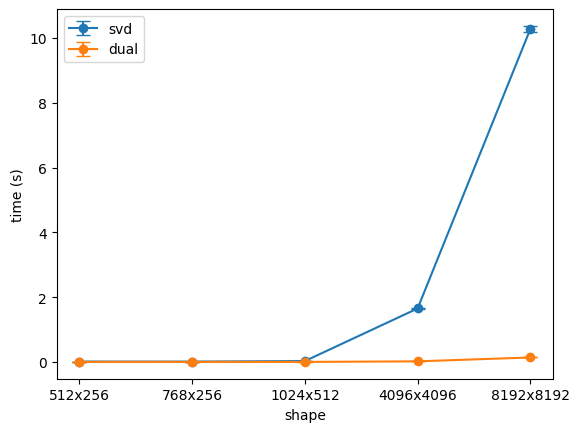

In [37]:
from matplotlib import pyplot as plt


x = df['shape']

plt.errorbar(x, df['svd_time_s_mean'], yerr=df['svd_time_s_std'], label='svd', capsize=5, marker='o')
plt.errorbar(x, df['dual_time_s_mean'], yerr=df['dual_time_s_std'], label='dual', capsize=5, marker='o')

plt.xlabel('shape')
plt.ylabel('time (s)')
plt.legend()
plt.show()

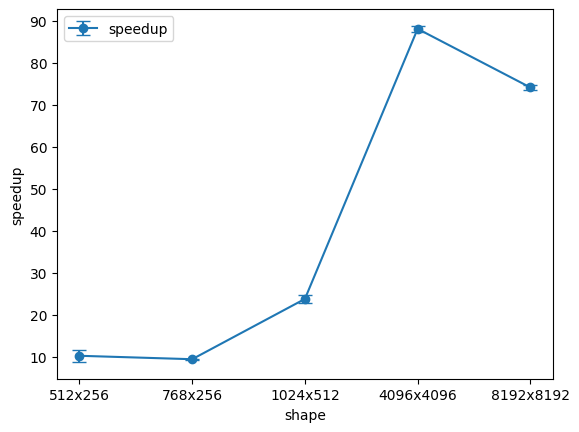

In [38]:
plt.errorbar(x, df['speedup_svd_over_dual_mean'], yerr=df['speedup_svd_over_dual_std'], label='speedup', capsize=5, marker='o')
plt.xlabel('shape')
plt.ylabel('speedup')
plt.legend()

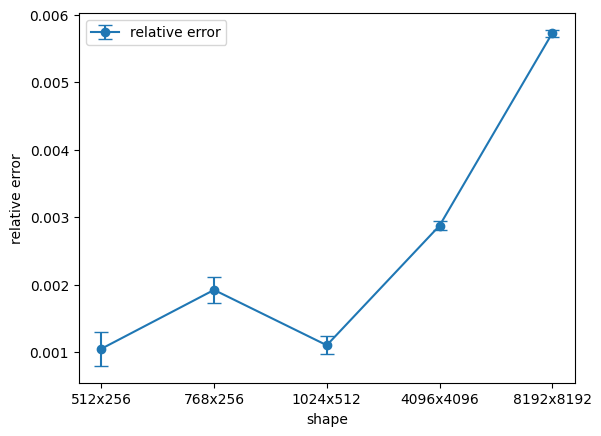

In [39]:
plt.errorbar(x, df['relative_error_mean'], yerr=df['relative_error_std'], label='relative error', capsize=5, marker='o')
plt.xlabel('shape')
plt.ylabel('relative error')
plt.legend()